# Latency analysis

In [1]:
recording_file = "2020-07-15T11-16-09"

In [2]:
import os

import pandas as pd
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from ptinsight.common.latency import calculate_latencies

sb.set(
    style="white",
    font_scale=1.6,
    rc={
        'lines.linewidth': 1.2,
        'axes.titleweight': 'bold',
    }
)

In [3]:
def add_time(data):
    """Add time column starting at 0 s based on the first timestamp"""
    data.sort_values("ingress_ingestion_timestamp", inplace=True)
    data.reset_index(inplace=True)
    data["t"] = (data["ingress_ingestion_timestamp"] - data["ingress_ingestion_timestamp"][0]) / 1000
    
def select_job(job):
    """Get all rows for a specific job"""
    return data[data["job"] == job]
    
def format(axs=None, space_factor=1):
    """Format the plot using the common style"""
    if axs is None:
        axs = [plt.gca()]
    for ax in axs:
        ax.get_xaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())

        ax.grid(b=True, which='major', linewidth=1.0)
        ax.grid(b=True, which='minor', linewidth=0.5, linestyle='-.')
    
    plt.tight_layout(0.1, .4*space_factor, .4*space_factor)
    
def save(name, format="png"):
    """Save the plot to the plots folder"""
    os.makedirs("plots", exist_ok=True)
    plt.savefig(f'plots/plot_{name}.{format}')

## Preprocessing

In [4]:
data = pd.read_csv(f"recordings/{recording_file}.csv")
add_time(data)
calculate_latencies(data)

jobs = pd.unique(data["job"])
n_jobs = len(jobs)
latency_cols = [col for col in data if col.startswith("latency")]
latency_cols_no_e2e = [col for col in latency_cols if not "end_to_end" in col]

## Descriptive statistics of latencies per job

In [5]:
for job in jobs:
    display(Markdown(f"#### Job: {job}"))
    display(select_job(job)[latency_cols].describe())

#### Job: vehicle-count

,latency_end_to_end,latency_ingest_to_processing,latency_processing,latency_processing_to_ui
count,8590.000000,8590.000000,8590.000000,8590.000000
mean,4427.911758,51.743073,4199.420955,176.747730
std,1539.780026,107.269082,1530.837511,146.608992
min,1175.000000,2.000000,883.000000,4.000000
25%,3215.250000,9.000000,2988.000000,78.000000
50%,4441.000000,15.000000,4228.500000,136.000000
75%,5628.750000,30.000000,5398.000000,225.000000
max,9267.000000,1060.000000,9071.000000,1091.000000


#### Job: delay-statistics

,latency_end_to_end,latency_ingest_to_processing,latency_processing,latency_processing_to_ui
count,8589.000000,8589.000000,8589.000000,8589.000000
mean,4901.632204,49.645593,4677.744673,174.241937
std,1641.157058,106.333638,1655.139268,144.025535
min,1270.000000,2.000000,941.000000,2.000000
25%,3550.000000,7.000000,3286.000000,79.000000
50%,4933.000000,13.000000,4626.000000,133.000000
75%,6210.000000,28.000000,6028.000000,225.000000
max,10949.000000,1018.000000,10825.000000,1087.000000


## Latency distribution per job

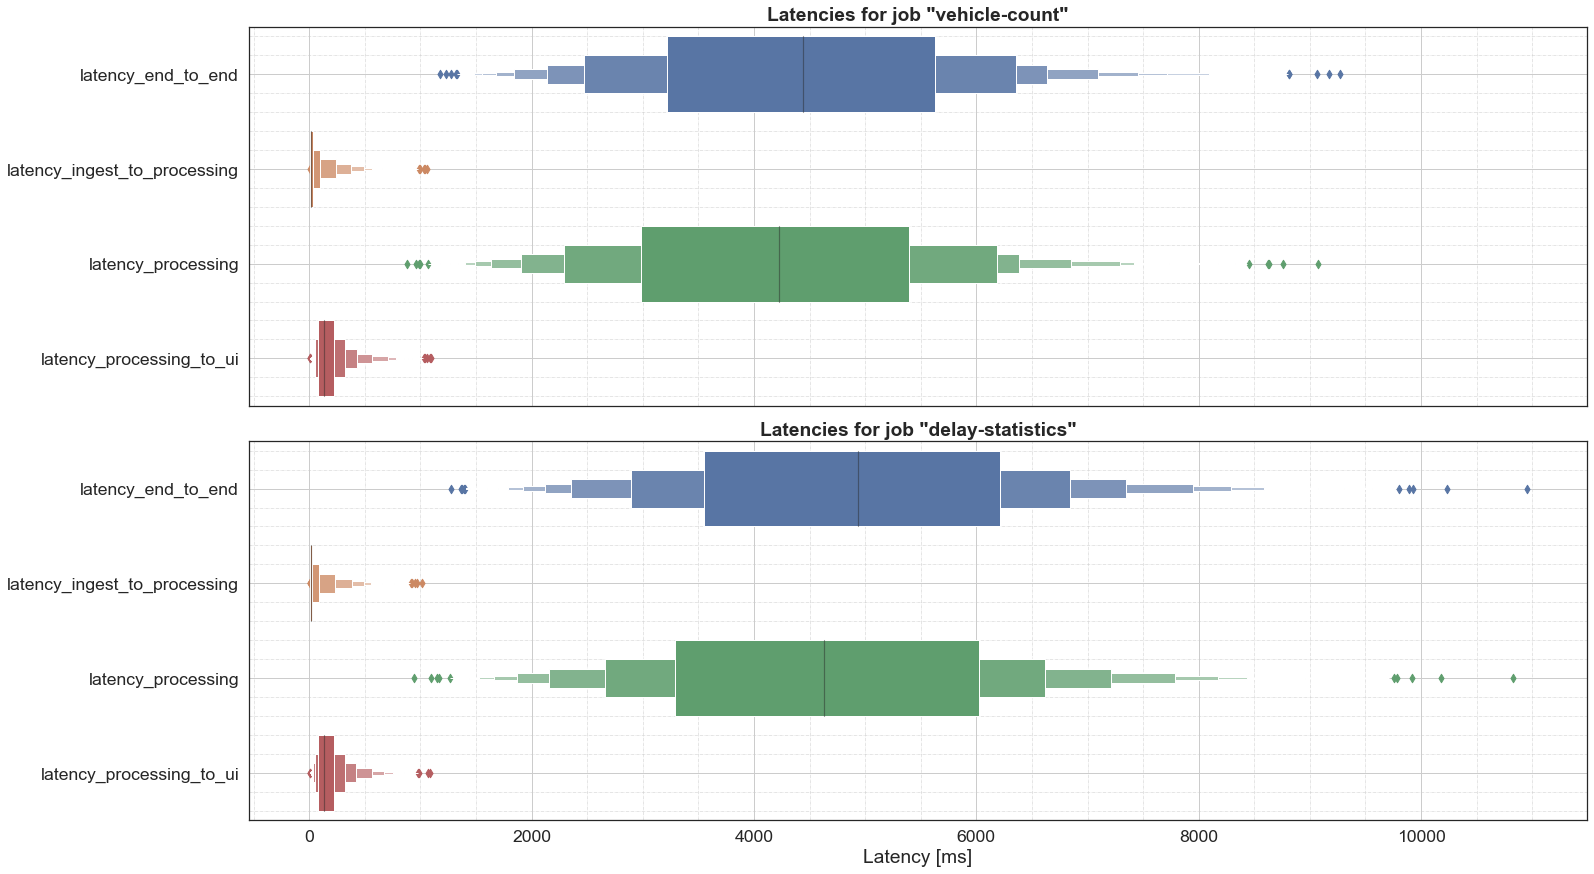

In [6]:
def plot_latency_distribution():
    _, axs = plt.subplots(n_jobs, 1, sharex=True, figsize=[22, 6*n_jobs])
    
    for i, job in enumerate(jobs):
        ax = axs[i]
        
        sb.boxenplot(data=select_job(job)[latency_cols], orient="h", ax=ax)
        
        ax.set_title(f"Latencies for job \"{job}\"")
        if i+1 == len(jobs):
            ax.set_xlabel("Latency [ms]")
        
    format(axs, space_factor=2)
    save("latency_distribution")
    
plot_latency_distribution()

## Latency over time per job

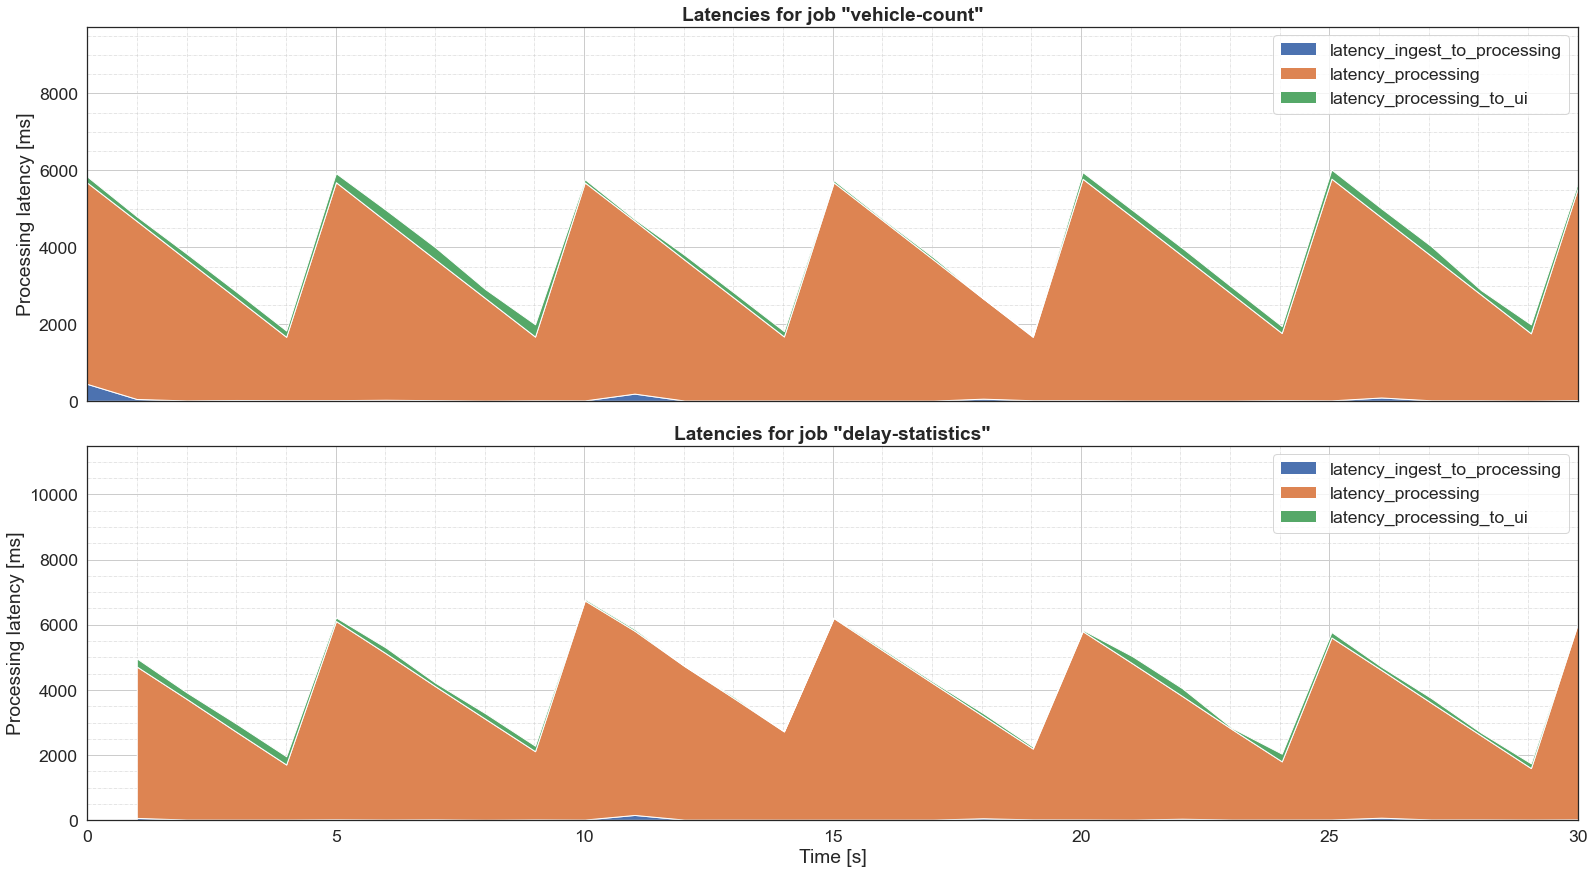

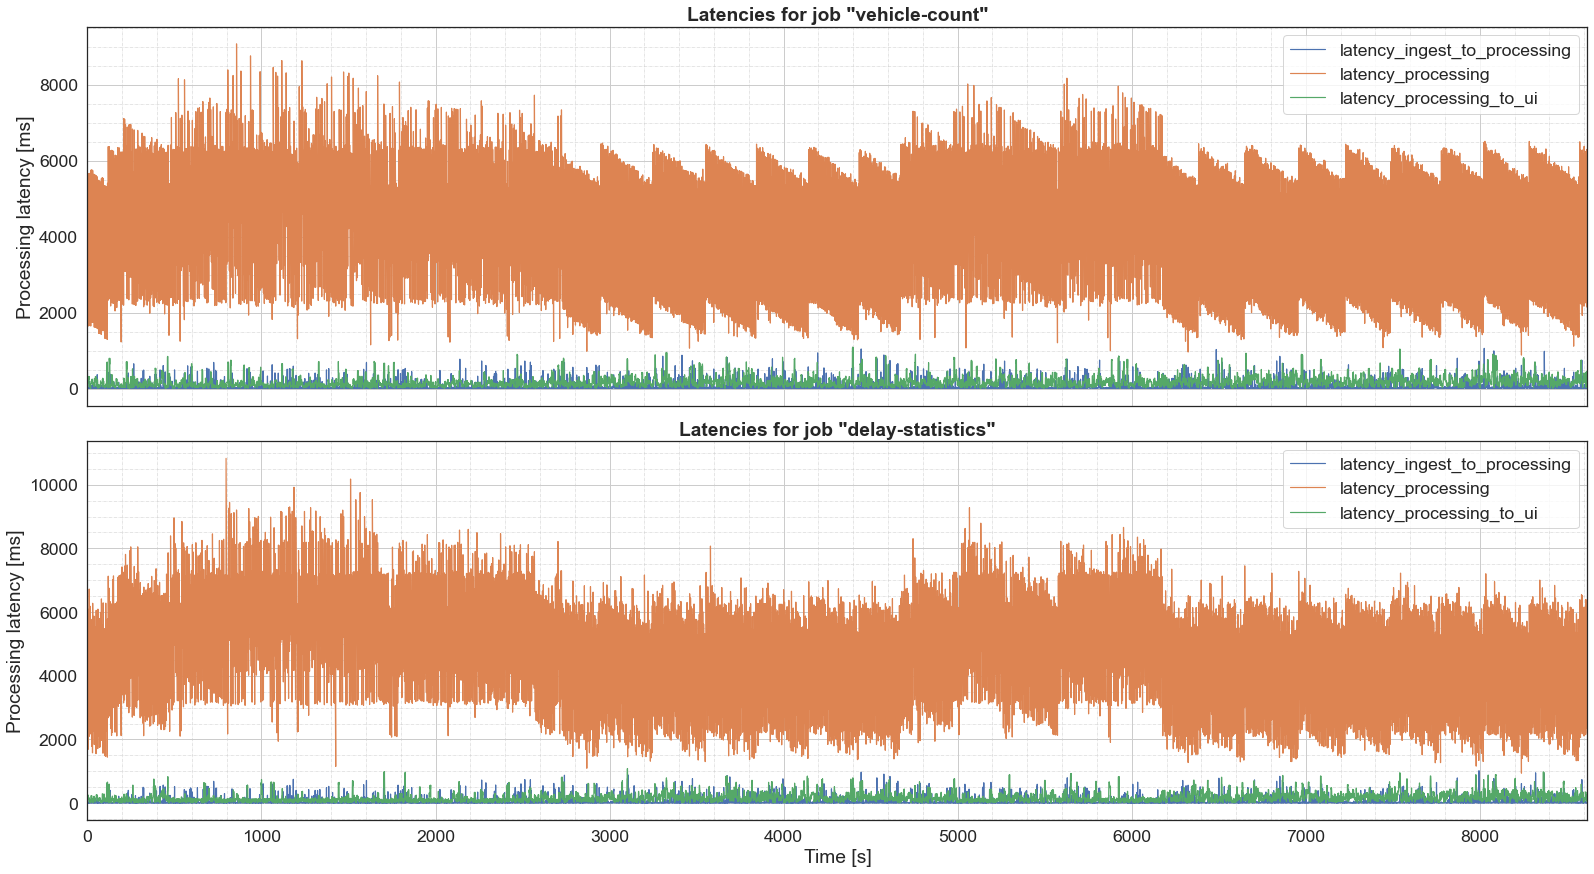

In [7]:
def plot_latency_over_time():
    for max_t in [30, int(data["t"].max())]:
        _, axs = plt.subplots(n_jobs, 1, sharex=True, figsize=[22, 6*n_jobs])
        
        for i, job in enumerate(jobs):
            job_data = select_job(job)
            ax = axs[i]
            
            if max_t <= 60:
                ax.stackplot(job_data["t"], job_data[latency_cols_no_e2e].T, labels=latency_cols_no_e2e)
            else:
                # Stack plot is weird when there are lots of samples, therefore use regular lineplot
                for col in latency_cols_no_e2e:
                    ax.plot(job_data["t"], job_data[col], label=col)
            
            ax.set_xlim([0, max_t])
            ax.set_ylabel("Processing latency [ms]")
            ax.set_title(f"Latencies for job \"{job}\"")
            ax.legend()
            if i+1 == len(jobs):
                ax.set_xlabel("Time [s]")
        
        format(axs, space_factor=2)
        save(f"latency_trend_{max_t}")
    
plot_latency_over_time()